In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import sem, t
import matplotlib.patches as mpatches


In [25]:
ruta = "results/validation_gaps/__VALIDATION_ROBUSTNESS_AND_ERRORS/global_error_validation.csv"
# Cargar datos
df = pd.read_csv(ruta)

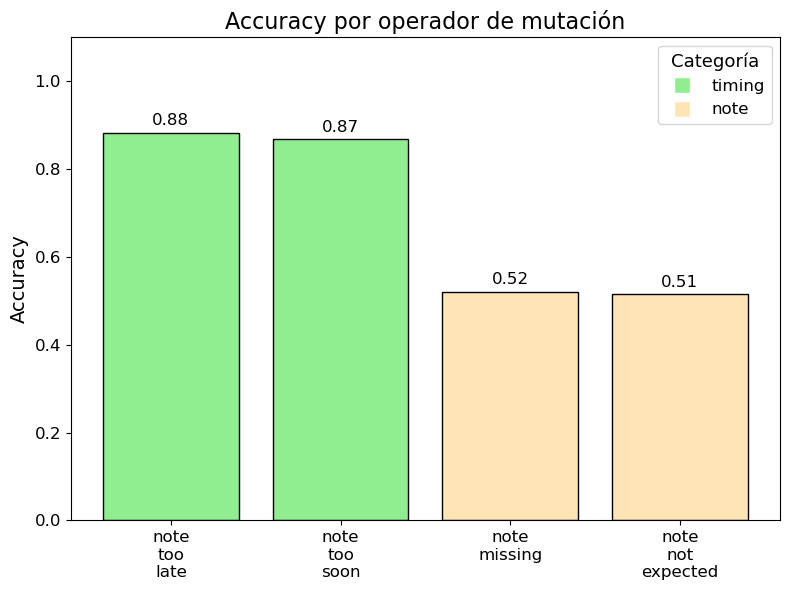

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Datos simulados (sustituye esto si ya tienes `accuracy_by_mutation` cargado)
accuracy_by_mutation = pd.DataFrame({
    "mutation_name": ["note_too_late", "note_too_soon", "note_missing", "note_not_expected"],
    "accuracy": [0.882883, 0.868644, 0.521127, 0.514644]
})

# Etiquetas de eje X con salto de línea
x_labels = accuracy_by_mutation["mutation_name"].str.replace("_", "\n", regex=False)

# Colores personalizados por categoría
color_mapping = {
    "note_too_late": "lightgreen",
    "note_too_soon": "lightgreen",
    "note_missing": "moccasin",
    "note_not_expected": "moccasin"
}
custom_colors = accuracy_by_mutation["mutation_name"].map(color_mapping).tolist()

# Crear gráfico
plt.figure(figsize=(8, 6))
bars = plt.bar(x_labels, accuracy_by_mutation["accuracy"], color=custom_colors, edgecolor="black")

# Añadir etiquetas sobre las barras
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f"{height:.2f}",
             ha='center', va='bottom', fontsize=12)

# Añadir leyenda para las categorías
legend_patches = [
    plt.Line2D([0], [0], marker='s', color='w', label='timing', markerfacecolor='lightgreen', markersize=12),
    plt.Line2D([0], [0], marker='s', color='w', label='note', markerfacecolor='moccasin', markersize=12)
]
plt.legend(handles=legend_patches, title="Categoría", loc='upper right', fontsize=12, title_fontsize=13)

# Estética
plt.ylim(0, 1.1)
plt.ylabel("Accuracy", fontsize=14)
plt.title("Accuracy por operador de mutación", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.grid(axis='y', linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("accuracy_by_mutation.pdf", format='pdf')
plt.show()


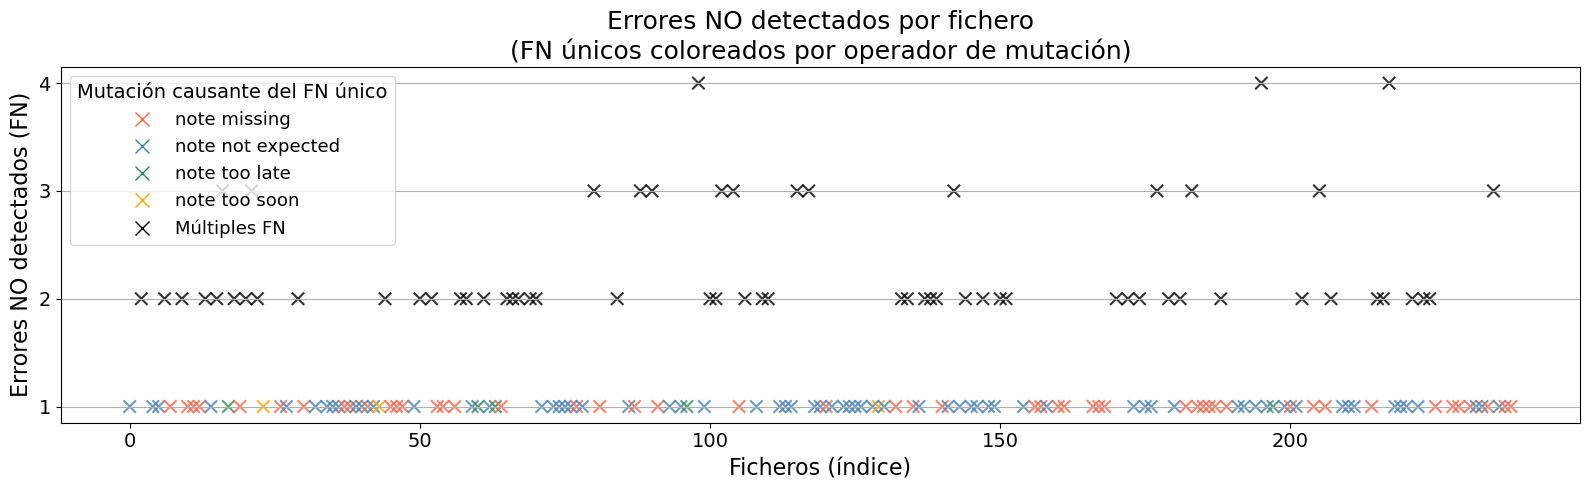

In [26]:

# Filtrar solo filas con errores introducidos (>0)
df_filtered = df[df["total_errors_introduced"] > 0].copy()

# Marcar errores no detectados (FN)
df_filtered["is_FN"] = df_filtered["detected_errors"] < df_filtered["total_errors_introduced"]

# Calcular cuántos FN hay por fichero
fn_per_file = df_filtered.groupby("midi_id")["is_FN"].sum().reset_index()
fn_per_file.columns = ["midi_id", "num_FN_mutations"]

# Detectar qué mutación falló cuando solo hay un FN
single_fn = df_filtered[df_filtered["is_FN"] == True].copy()
single_fn_counts = single_fn.groupby("midi_id")["mutation_name"].agg(list).reset_index()
single_fn_counts["num_FN"] = single_fn_counts["mutation_name"].apply(len)
single_fn_counts["dominant_mutation"] = single_fn_counts.apply(
    lambda row: row["mutation_name"][0] if row["num_FN"] == 1 else None, axis=1
)

# Unir la mutación dominante a la tabla de resumen
fn_combined = pd.merge(fn_per_file, single_fn_counts[["midi_id", "dominant_mutation"]], on="midi_id", how="left")

# Definir colores para mutaciones
colors = {
    "note_missing": "tomato",
    "note_not_expected": "steelblue",
    "note_too_late": "seagreen",
    "note_too_soon": "orange",
}

# Asignar color: por mutación si FN = 1, negro si FN > 1
fn_combined["color"] = fn_combined["dominant_mutation"].map(colors)
fn_combined.loc[fn_combined["num_FN_mutations"] > 1, "color"] = "black"

# Filtrar solo ficheros donde haya al menos 1 FN
fn_nonzero = fn_combined[fn_combined["num_FN_mutations"] > 0].copy()

# Crear gráfico
plt.figure(figsize=(16, 5))
plt.scatter(fn_nonzero.index, fn_nonzero["num_FN_mutations"],
            c=fn_nonzero["color"], alpha=0.8, s=80, marker="x")

# Estética
plt.yticks(range(1, 5), fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Ficheros (índice)", fontsize=16)
plt.ylabel("Errores NO detectados (FN)", fontsize=16)
plt.title("Errores NO detectados por fichero\n(FN únicos coloreados por operador de mutación)", fontsize=18)

# Leyenda
legend_patches = [
    plt.Line2D([0], [0], marker='x', color='w', label=label.replace("_", " "),
               markerfacecolor=color, markeredgecolor=color, markersize=10)
    for label, color in colors.items()
]
legend_patches.append(
    plt.Line2D([0], [0], marker='x', color='w', label="Múltiples FN",
               markerfacecolor="black", markeredgecolor="black", markersize=10)
)

plt.legend(handles=legend_patches, title="Mutación causante del FN único", fontsize=13, title_fontsize=14)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


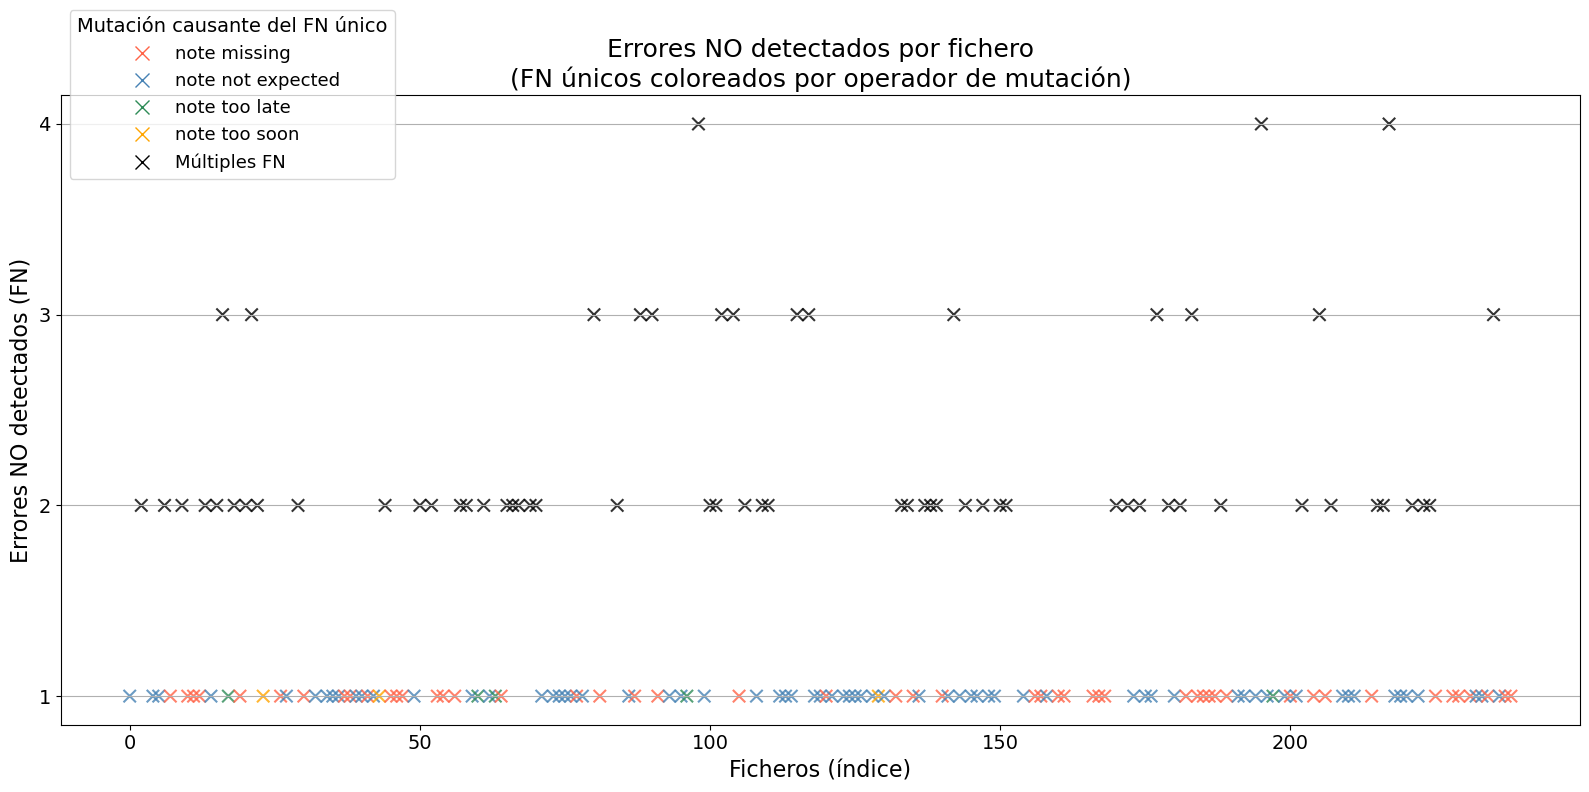

In [32]:
# Crear gráfico
plt.figure(figsize=(16, 8))
plt.scatter(fn_nonzero.index, fn_nonzero["num_FN_mutations"],
            c=fn_nonzero["color"], alpha=0.8, s=80, marker="x")

# Estética
plt.yticks(range(1, 5), fontsize=14)
plt.xticks(fontsize=14)
plt.xlabel("Ficheros (índice)", fontsize=16)
plt.ylabel("Errores NO detectados (FN)", fontsize=16)
plt.title("Errores NO detectados por fichero\n(FN únicos coloreados por operador de mutación)", fontsize=18)

# Leyenda en la esquina superior izquierda
legend_patches = [
    plt.Line2D([0], [0], marker='x', color='w', label=label.replace("_", " "),
               markerfacecolor=color, markeredgecolor=color, markersize=10)
    for label, color in colors.items()
]
legend_patches.append(
    plt.Line2D([0], [0], marker='x', color='w', label="Múltiples FN",
               markerfacecolor="black", markeredgecolor="black", markersize=10)
)

plt.legend(handles=legend_patches,
           title="Mutación causante del FN único",
           fontsize=13, title_fontsize=14,
           loc='upper left', bbox_to_anchor=(0, 1.15))

plt.grid(axis='y')
plt.tight_layout()
plt.savefig("histograma_errores_fn.pdf", format='pdf')
plt.show()


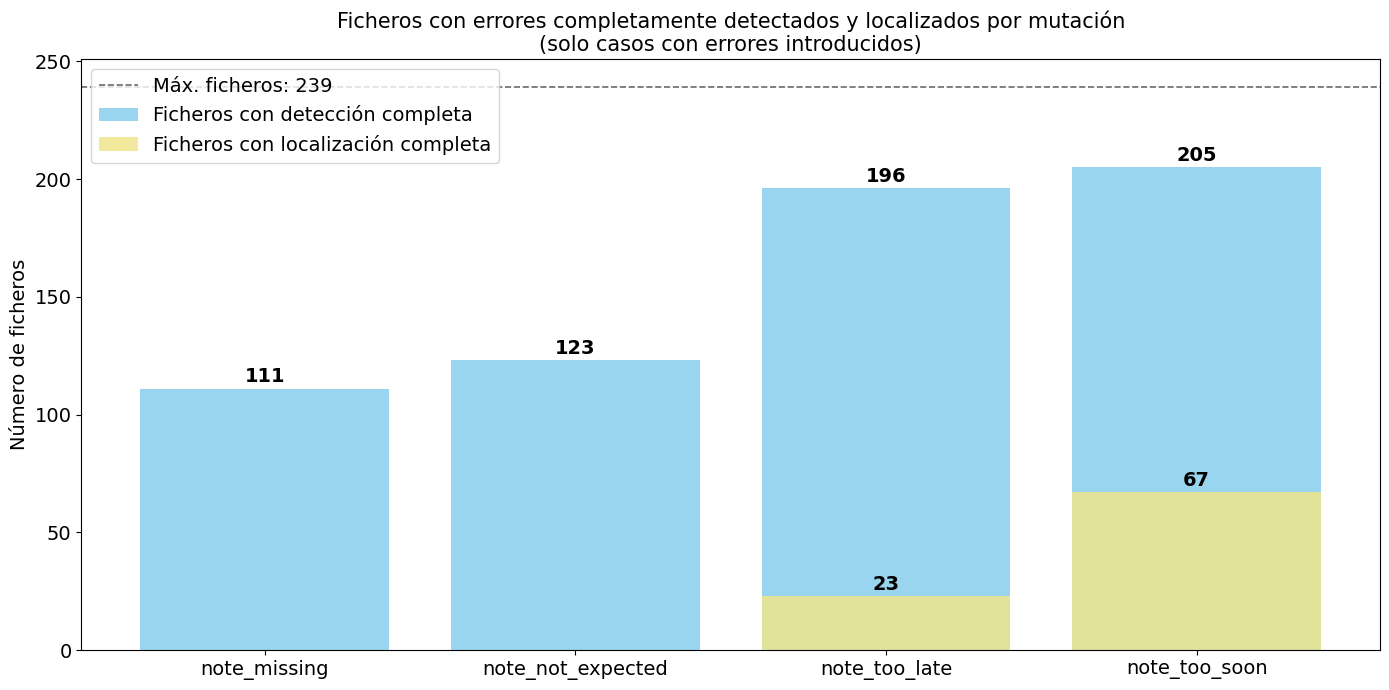

In [23]:
# Filtrar solo filas con errores introducidos (> 0)
df_filtered = df[df["total_errors_introduced"] > 0].copy()

# Evaluar si los errores introducidos se detectaron o localizaron completamente (fila a fila)
df_filtered["fully_detected"] = df_filtered["detected_errors"] >= df_filtered["total_errors_introduced"]
df_filtered["fully_located"] = df_filtered["located_errors"] >= df_filtered["total_errors_introduced"]

# Agrupar por mutation_name y fichero
mutation_file_status_filtered = df_filtered.groupby(["mutation_name", "midi_id"]).agg({
    "fully_detected": "all",
    "fully_located": "all"
}).reset_index()

# Contar por mutación cuántos ficheros cumplen la condición
mutation_detection_summary_filtered = mutation_file_status_filtered.groupby("mutation_name").agg(
    total_cases=("midi_id", "count"),
    fully_detected=("fully_detected", "sum"),
    fully_located=("fully_located", "sum")
).reset_index()

# Preparar datos para graficar
x = mutation_detection_summary_filtered["mutation_name"]
detected = mutation_detection_summary_filtered["fully_detected"]
located = mutation_detection_summary_filtered["fully_located"]
max_files = mutation_detection_summary_filtered["total_cases"].max()

# Crear gráfico
plt.figure(figsize=(14, 7))
bar1 = plt.bar(x, detected, label="Ficheros con detección completa", alpha=0.85, color="skyblue")
bar2 = plt.bar(x, located, label="Ficheros con localización completa", alpha=0.85, color="khaki")

# Etiquetas sobre las barras
for rect in bar1:
    height = rect.get_height()
    if height > 0:
        plt.text(rect.get_x() + rect.get_width() / 2, height + 1, f"{int(height)}",
                 ha='center', va='bottom', fontsize=14, color="black", fontweight='bold')

for rect in bar2:
    height = rect.get_height()
    if height > 0:
        plt.text(rect.get_x() + rect.get_width() / 2, height + 1, f"{int(height)}",
                 ha='center', va='bottom', fontsize=14, color="black", fontweight='bold')

# Línea de referencia
plt.axhline(y=max_files, color="dimgray", linestyle="--", linewidth=1.2, label=f"Máx. ficheros: {max_files}")

# Estética
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel("Número de ficheros", fontsize=14)
plt.title("Ficheros con errores completamente detectados y localizados por mutación\n(solo casos con errores introducidos)", fontsize=15)
plt.legend(fontsize=14)
plt.tight_layout()
plt.savefig("histogram_validation_errors.pdf", format='pdf')

plt.show()

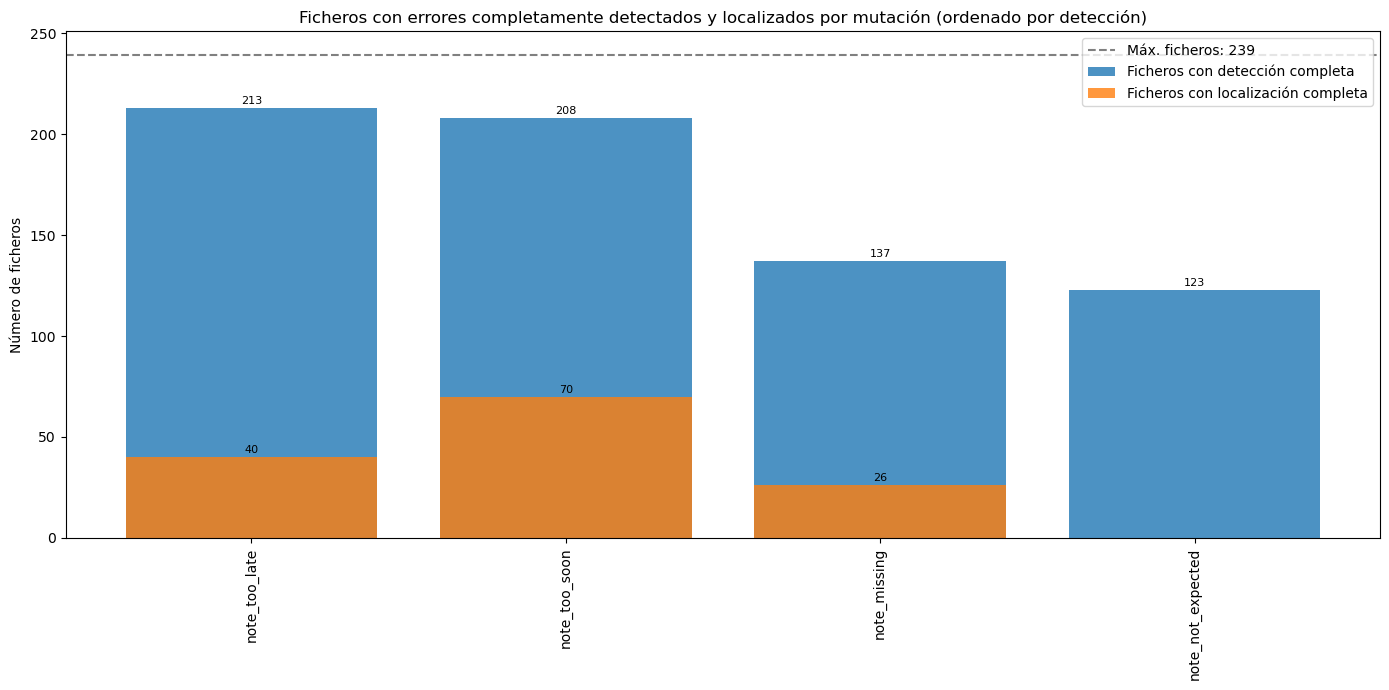

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Supongamos que tu DataFrame original se llama df
# Paso 1: Agrupar por mutation_name y midi_id
mutation_file_sums = df.groupby(["mutation_name", "midi_id"])[
    ["detected_errors", "located_errors", "total_errors_introduced"]
].sum().reset_index()

# Paso 2: Determinar si todos los errores fueron detectados o localizados
mutation_file_sums["all_detected"] = mutation_file_sums["detected_errors"] >= mutation_file_sums["total_errors_introduced"]
mutation_file_sums["all_located"] = mutation_file_sums["located_errors"] >= mutation_file_sums["total_errors_introduced"]

# Paso 3: Agrupar por mutación y contar los casos
mutation_detection_summary = mutation_file_sums.groupby("mutation_name").agg(
    total_cases=("midi_id", "count"),
    fully_detected=("all_detected", "sum"),
    fully_located=("all_located", "sum")
).reset_index()

# Paso 4: Ordenar por número de detecciones completas
mutation_detection_summary_sorted = mutation_detection_summary.sort_values("fully_detected", ascending=False)

# Paso 5: Extraer datos para graficar
x = mutation_detection_summary_sorted["mutation_name"]
detected = mutation_detection_summary_sorted["fully_detected"]
located = mutation_detection_summary_sorted["fully_located"]
max_files = mutation_detection_summary_sorted["total_cases"].max()

# Paso 6: Crear el gráfico
plt.figure(figsize=(14, 7))
bar1 = plt.bar(x, detected, label="Ficheros con detección completa", alpha=0.8)
bar2 = plt.bar(x, located, label="Ficheros con localización completa", alpha=0.8)

# Añadir etiquetas numéricas sobre cada barra
for rect in bar1:
    height = rect.get_height()
    if height > 0:
        plt.text(rect.get_x() + rect.get_width() / 2, height + 1, f"{int(height)}",
                 ha='center', va='bottom', fontsize=8)

for rect in bar2:
    height = rect.get_height()
    if height > 0:
        plt.text(rect.get_x() + rect.get_width() / 2, height + 1, f"{int(height)}",
                 ha='center', va='bottom', fontsize=8)

# Línea horizontal indicando el máximo
plt.axhline(y=max_files, color="gray", linestyle="--", label=f"Máx. ficheros: {max_files}")

# Ajustes de etiquetas y formato
plt.xticks(rotation=90)
plt.ylabel("Número de ficheros")
plt.title("Ficheros con errores completamente detectados y localizados por mutación (ordenado por detección)")
plt.legend()
plt.tight_layout()
plt.show()


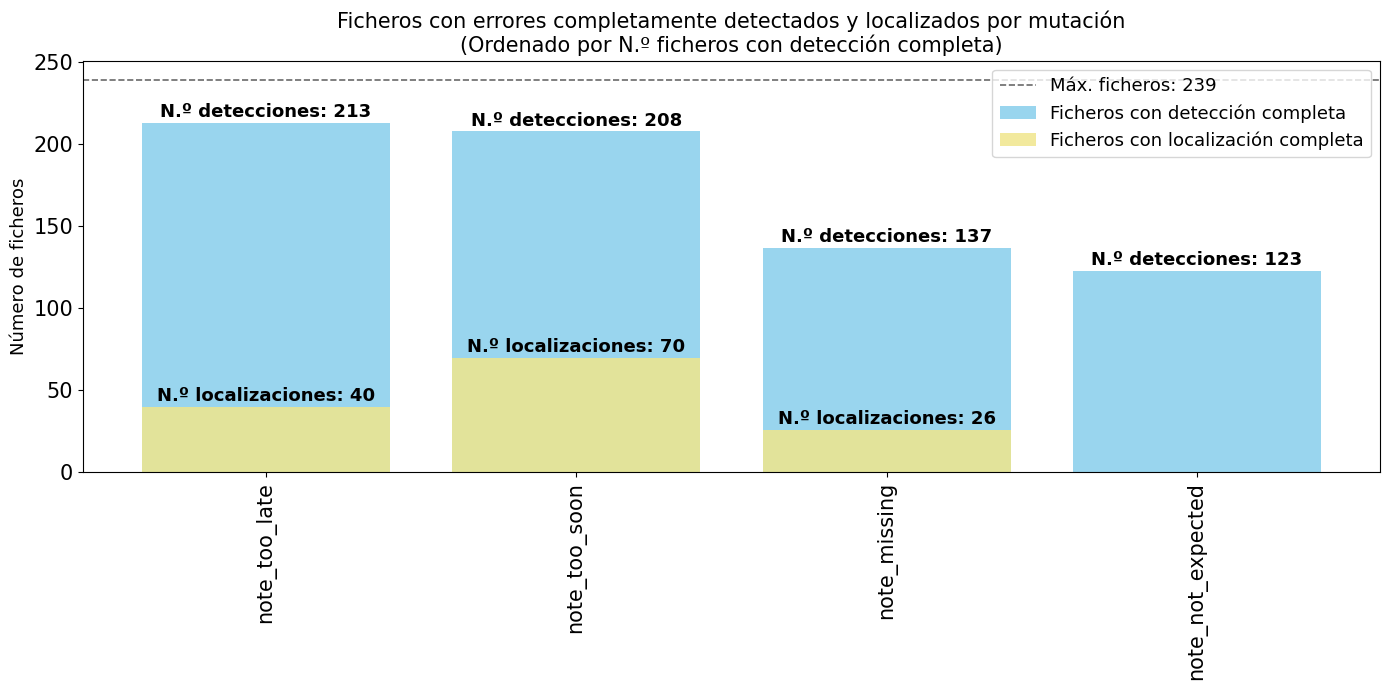

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Paso 1: Agrupar por mutación y fichero
mutation_file_sums = df.groupby(["mutation_name", "midi_id"])[
    ["detected_errors", "located_errors", "total_errors_introduced"]
].sum().reset_index()

# Paso 2: Determinar detección y localización completas
mutation_file_sums["all_detected"] = mutation_file_sums["detected_errors"] >= mutation_file_sums["total_errors_introduced"]
mutation_file_sums["all_located"] = mutation_file_sums["located_errors"] >= mutation_file_sums["total_errors_introduced"]

# Paso 3: Resumir por mutación
mutation_detection_summary = mutation_file_sums.groupby("mutation_name").agg(
    total_cases=("midi_id", "count"),
    fully_detected=("all_detected", "sum"),
    fully_located=("all_located", "sum")
).reset_index()

# Paso 4: Ordenar por número de detecciones completas
mutation_detection_summary_sorted = mutation_detection_summary.sort_values("fully_detected", ascending=False)

# Paso 5: Preparar datos para graficar
x = mutation_detection_summary_sorted["mutation_name"]
detected = mutation_detection_summary_sorted["fully_detected"]
located = mutation_detection_summary_sorted["fully_located"]
max_files = mutation_detection_summary_sorted["total_cases"].max()

# Paso 6: Crear gráfico
plt.figure(figsize=(14, 7))
bar1 = plt.bar(x, detected, label="Ficheros con detección completa", alpha=0.85, color="skyblue")
bar2 = plt.bar(x, located, label="Ficheros con localización completa", alpha=0.85, color="khaki")

# Añadir etiquetas sobre las barras
for rect in bar1:
    height = rect.get_height()
    if height > 0:
        plt.text(rect.get_x() + rect.get_width() / 2, height + 1, f"N.º detecciones: {int(height)}",
                 ha='center', va='bottom', fontsize=14, color="black", fontweight='bold')

for rect in bar2:
    height = rect.get_height()
    if height > 0:
        plt.text(rect.get_x() + rect.get_width() / 2, height + 1, f"N.º localizaciones: {int(height)}",
                 ha='center', va='bottom', fontsize=14, color="black", fontweight='bold')

# Línea horizontal como referencia del máximo
plt.axhline(y=max_files, color="dimgray", linestyle="--", linewidth=1.2, label=f"Máx. ficheros: {max_files}")

# Estética y presentación
plt.xticks(rotation=90, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel("Número de ficheros", fontsize=14)
plt.title("Ficheros con errores completamente detectados y localizados por mutación\n(Ordenado por N.º ficheros con detección completa)", fontsize=15)
plt.legend(fontsize=14)
plt.tight_layout()
plt.show()


In [16]:
mutation_file_sums

,mutation_name,midi_id,detected_errors,located_errors,total_errors_introduced,all_detected,all_located
0,note_missing,-D1wc-fine-aligned,1,0,1,True,False
1,note_missing,-M1wc-fine-aligned,1,0,1,True,False
2,note_missing,-Sswc-fine-aligned,1,0,1,True,False
3,note_missing,-k1wc-fine-aligned,0,0,0,True,True
4,note_missing,141wc-fine-aligned,1,0,1,True,False
...,...,...,...,...,...,...,...
951,note_too_soon,yw1wc-fine-aligned,1,1,1,True,True
952,note_too_soon,z41wc-fine-aligned,0,0,1,False,False
953,note_too_soon,zD1wc-fine-aligned,11,0,1,True,False
954,note_too_soon,zV1wc-fine-aligned,8,0,1,True,False
